In [1]:
# Importing dependencies:
import cv2
import glob
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Importing Keras dependencies:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Lambda
%matplotlib inline

print('Imported all dependencies!')

Using TensorFlow backend.


Imported all dependencies!


Variables created!
Number of vehicle images: 8792
Number of non-vehicles images: 8968
Total number of images: 17760


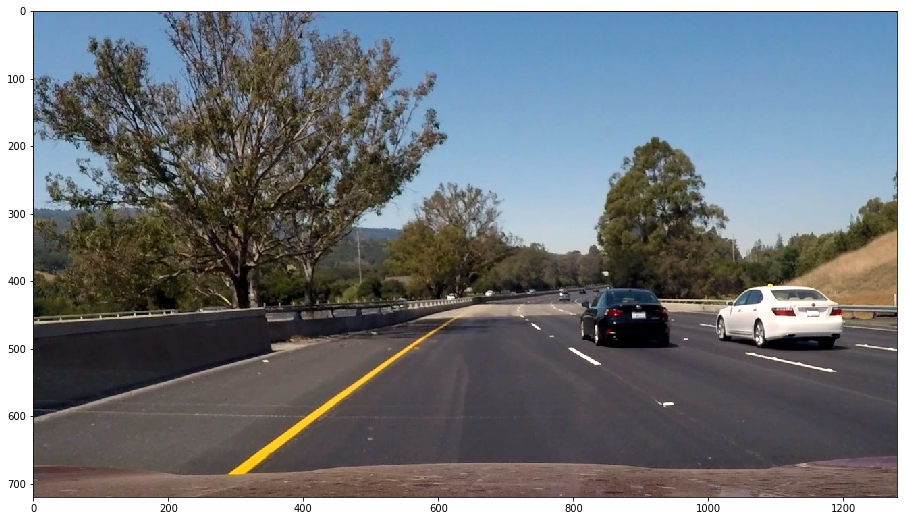

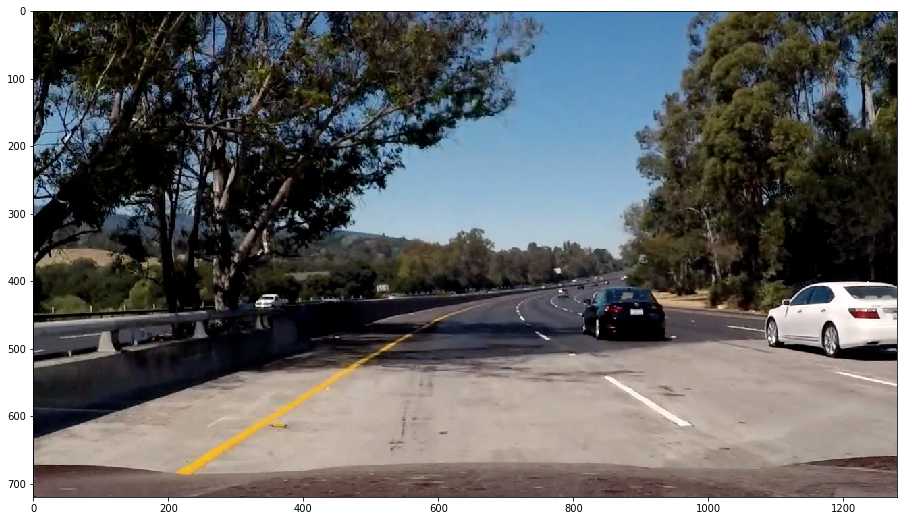

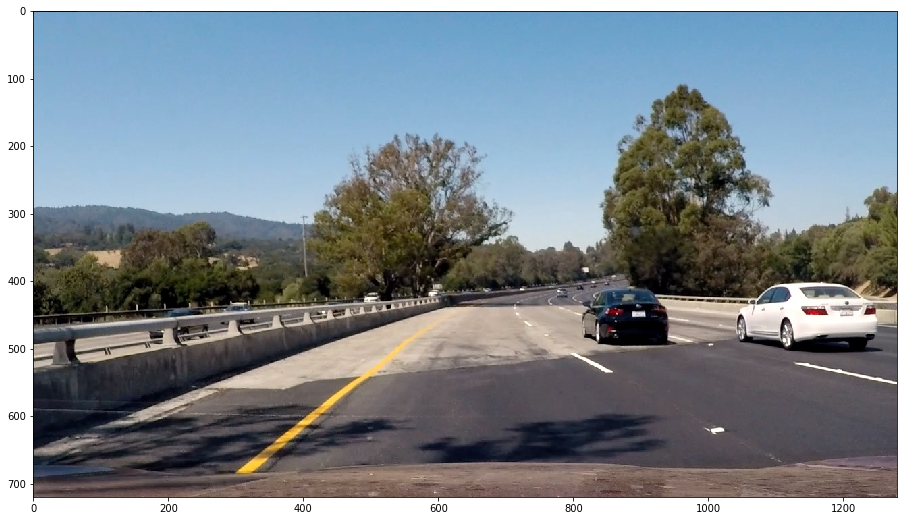

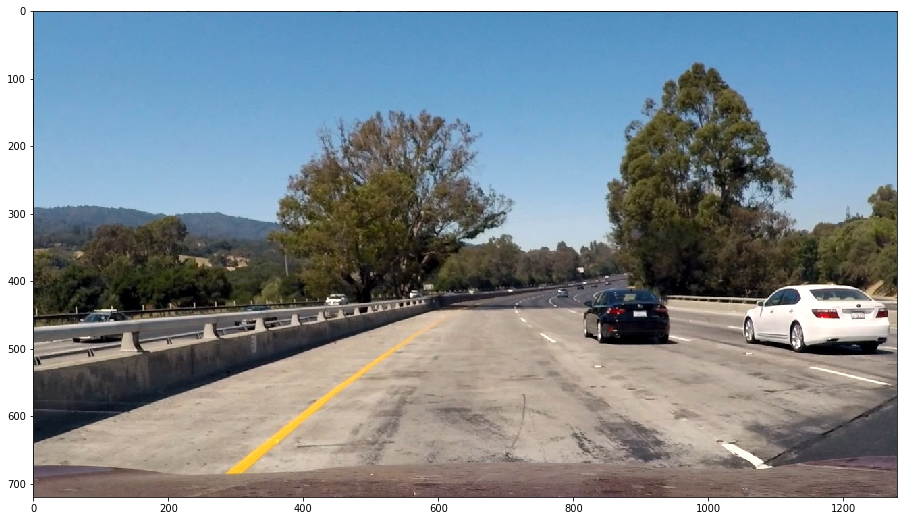

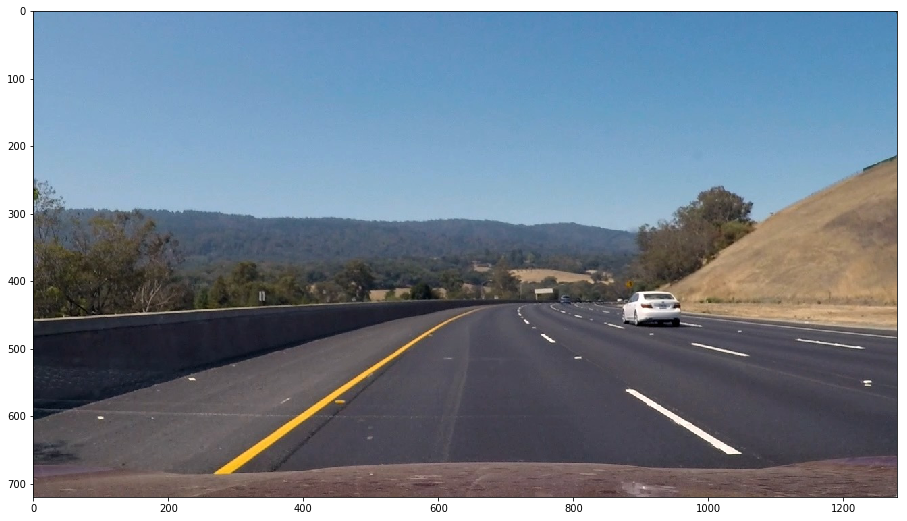

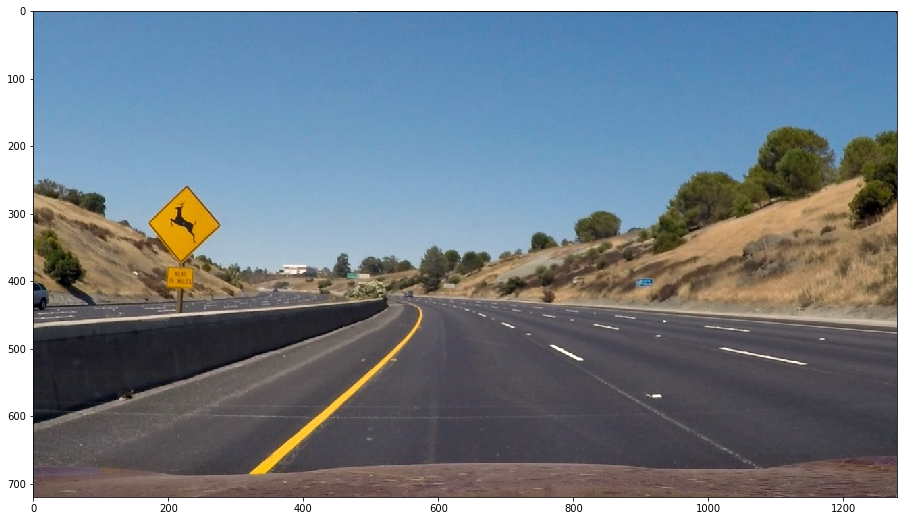

In [2]:
# Creating the variables where the images will be saved:
highway_test_images = glob.glob('test_images/*.jpg')
highway_vehicles_images = glob.glob('test_images/vehicles/**/*.png')
highway_non_vehicles_images = glob.glob('test_images/non-vehicles/**/*.png')
highway_all_images = glob.glob('test_images/**/**/*.png')

for images in highway_test_images:
    
    # Reading the images:
    highway_images = mpimg.imread(images)
    
    # Formatting the amount of columns and the size of the images that will be displayed:
    f, ax = plt.subplots(1, 1, figsize=(12, 9), sharey=True)
    f.tight_layout()
    
    # Original images:  
    plt.imshow(highway_images)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

print('Variables created!')
print('Number of vehicle images:', len(highway_vehicles_images))
print('Number of non-vehicles images:', len(highway_non_vehicles_images))
print('Total number of images:', len(highway_all_images))

In [3]:
# Appending the vehicles and non-vehicle images to an array:
cars = []
notcars = []
        
for image in highway_vehicles_images:
    cars.append(image)
    
for image in highway_non_vehicles_images:
    notcars.append(image)
    
print('Arrays created!')
print(len(cars))
print(len(notcars))

Arrays created!
8792
8968


In [11]:
# Defining the HOG features and visualization (extracted function from Udacity lesson):
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations = orient,
                                  pixels_per_cell = (pix_per_cell, pix_per_cell), 
                                  cells_per_block = (cell_per_block, cell_per_block), 
                                  transform_sqrt = False, visualise = True, feature_vector = False)
        return features, hog_image
    else:      
        
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                      pixels_per_cell = (pix_per_cell, pix_per_cell), 
                      cells_per_block = (cell_per_block, cell_per_block), 
                      transform_sqrt = False, visualise = False, feature_vector = feature_vec)
        return features

print('Function ready to use!')

Function ready to use!


Image saved in directory!


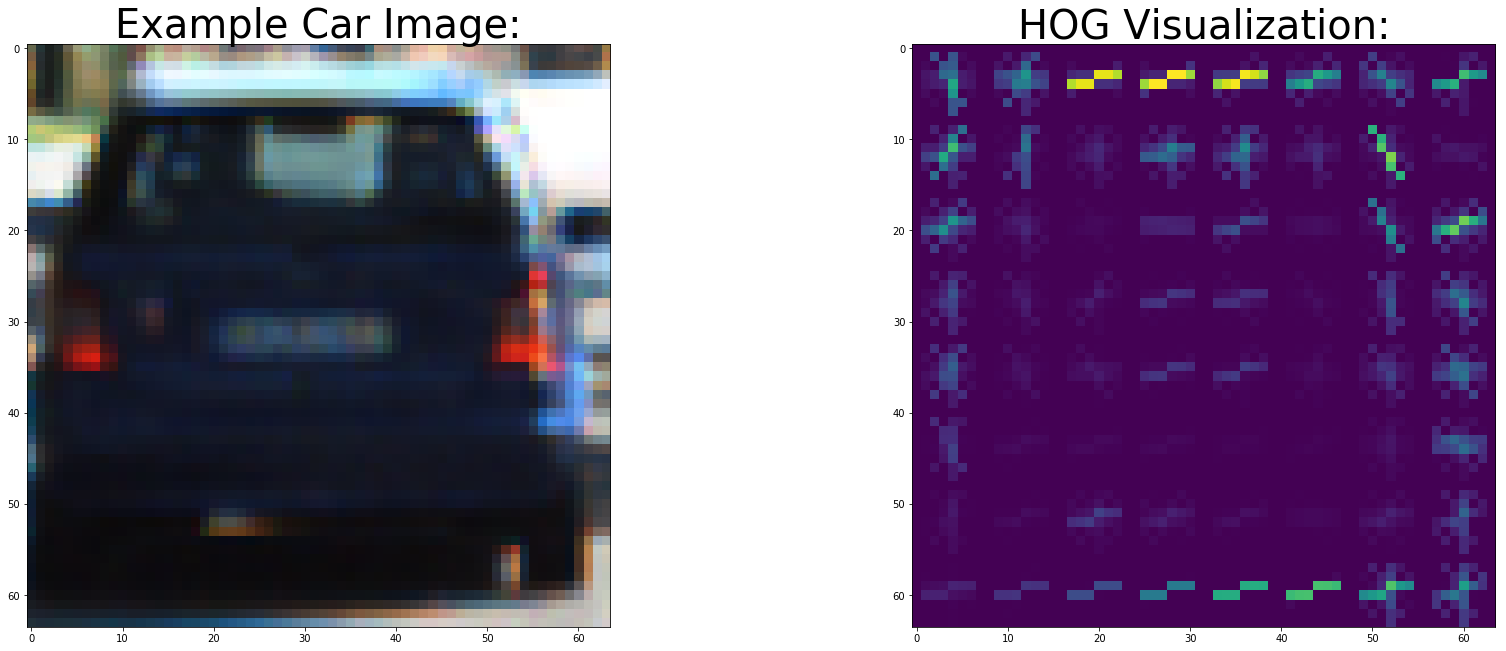

In [12]:
# Visualizing the pictures:
# Generate a random index to look at a car image:
ind = np.random.randint(0, len(cars))

# Read in the image:
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Formatting the amount of columns and the size of the images that will be displayed:
f, ax = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

# Example Car Image:  
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Example Car Image:', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# HOG Visualization:
ax[1].imshow(hog_image)
ax[1].set_title('HOG Visualization:', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.imsave('output_images/hog_image.jpg', hog_image)

print('Image saved in directory!')

In [13]:
# Define a function to compute binned color features (extracted function from Udacity lesson):  
def bin_spatial(img, size=(32, 32)):
    
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:, :, 0], size).ravel() 
    color2 = cv2.resize(img[:, :, 1], size).ravel() 
    color3 = cv2.resize(img[:, :, 2], size).ravel() 
    
    # Return the feature vector
    return np.hstack(color1, color2, color3)

print('Function ready to use!')

Function ready to use!


In [14]:
# Define a function to compute color histogram features (extracted function from Udacity lesson):
def color_hist(img, nbins=32):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

print('Function ready to use!')

Function ready to use!


In [16]:
# Define a function to extract features from a list of images (extracted function from Udacity lesson):
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_features=True, hist_features=True, hog_features=True):
    
    # Create a list to append feature vectors to:
    features = []
    
    # Iterate through the list of images:
    for file in imgs:
        
        file_features = []
        
        # Read in each one by one:
        image = mpimg.imread(file)
        
        # Applying color conversion if other than 'RGB':
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   
        
        # Applying bin_spatial() to get spatial color features:
        if spatial_features == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        # Applying color_hist() also with a color space option now:
        if hist_features == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
            # Applying the get_hog_features():
        if hog_features == True:
            
            # In case the channel is set to 'ALL':
            if hog_channel == 'ALL':
                
                # Create a empty array:
                hog_features = []
                
                # Loop through the images:
                for channel in range(feature_image.shape[2]):
                    
                    # Append images to empty array:
                    hog_features.append(get_hog_features(feature_image[:, :, channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        

            # All other channels:
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

            # Append the new feature vector to the features list
            file_features.append(hog_features)

            # Append the new feature vector to the features list
        features.append(np.concatenate((file_features)))
        
    # Return list of feature vectors
    return features

print('Function ready to use!')

Function ready to use!


In [ ]:
# Creating sliding windown function (extracted from Udacity lesson):
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
                        
    # If x and/or y start/stop positions are not defined, we set to image size:
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Computing the span of the region to be searched:
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Computing the number of pixels per step in x/y:
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy.window[1]*(1 - xy_overlap[1]))
    
    # Computing the number of windows in x/y:
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((xspan - ny_buffer) / ny_pxi_per_step)
    
    # Initializing a list to append window positions to:
    window_list = []
    
    # Looping through finding x and y window positions:
    for ys in range(ny_windows):
        for xs in range(nx_windows):
    
            # Calculating each window position:
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Appending window position to list:
            window_list.append((startx, starty), (endx, endy))
            
    # Returning the list of windows:
    return window_list

In [ ]:
# Setting up some pre-established numbers:
# Can be RGB, HSV, LUV, HLS, YUV, YCrCb:
colorspace = 'RGB' 
spatial_size = (16, 16)
hist_bins = 16
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Can be 0, 1, 2, or "ALL":
hog_channel = 0
spatial_features = True
hist_features = True
hog_features = True

car_features = extract_features(imgs, cspace='RGB', spatial_size, hist_bins, 
                                orient, pix_per_cell, cell_per_block, hog_channel, 
                                spatial_features, hist_features, hog_features):

